# **Rezbin AI Model v2.0 Development**

In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
from pathlib import Path

# opening dataset
dataset_path = Path('./dataset-resized/')
full_dataset = datasets.ImageFolder(root=dataset_path)
idx_labels = full_dataset.class_to_idx

In [3]:
from torch.utils.data import random_split
from torchvision.transforms import v2

# defining transformation pipeline
transform = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define train and test size
train_size = int(0.8 * len(full_dataset))
test_size = int(len(full_dataset) - train_size)
    
# splitting the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12156862..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34117645..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.796078

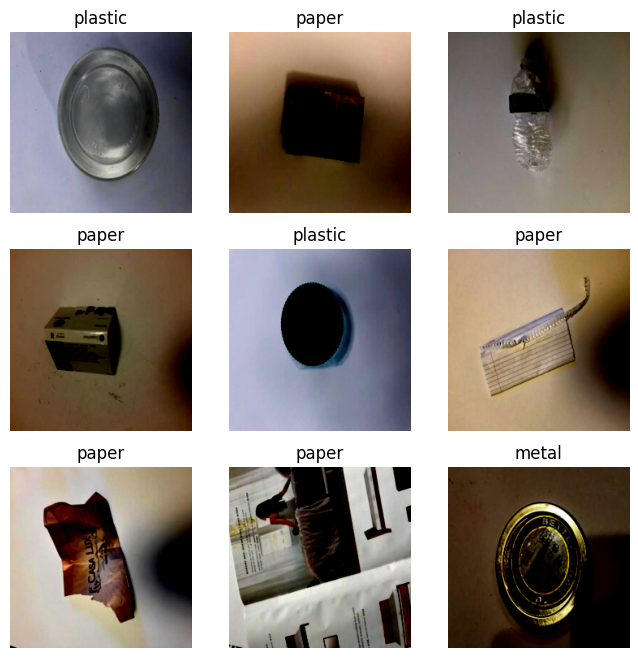

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(idx_labels.keys())[list(idx_labels.values()).index(label)])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [6]:
from torchvision import models
import torch.nn as nn

# Load the pre-trained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze feature layers (we're only training the classifier)
for param in vgg16.features.parameters():
    param.requires_grad = False


c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Modifying VGG-16's classifier to match our dataset
idx_labels = full_dataset.class_to_idx
num_classes = len(idx_labels)
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)


In [8]:
# Define loss function and optimizer
import torch.nn as nn
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)



In [ ]:
# Use GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)


vgg16.train()#LEZGAAAWWW

In [ ]:
from tqdm import tqdm  # for progress bar visual 😎

num_epochs = 5  # can change this later
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = vgg16(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:23<00:00,  2.71it/s]


Epoch [1/5], Loss: 0.8801, Accuracy: 65.46%


100%|██████████| 64/64 [00:20<00:00,  3.18it/s]


Epoch [2/5], Loss: 0.3234, Accuracy: 89.11%


100%|██████████| 64/64 [00:20<00:00,  3.14it/s]


Epoch [3/5], Loss: 0.1322, Accuracy: 95.45%


100%|██████████| 64/64 [00:20<00:00,  3.10it/s]


Epoch [4/5], Loss: 0.0558, Accuracy: 98.27%


100%|██████████| 64/64 [00:20<00:00,  3.19it/s]

Epoch [5/5], Loss: 0.0294, Accuracy: 99.46%


In [12]:
vgg16.eval()  #evaluation mode
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 84.58%
